In [122]:
#update libs
!pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install --upgrade inflect
!pip install --upgrade pprint
!pip install --upgrade hyperopt
!pip install --upgrade hpsklearn

Requirement already up-to-date: pandas in c:\anaconda\lib\site-packages (0.23.4)
Requirement already up-to-date: scikit-learn in c:\anaconda\lib\site-packages (0.20.2)
Requirement already up-to-date: inflect in c:\anaconda\lib\site-packages (2.1.0)
Requirement already up-to-date: pprint in c:\anaconda\lib\site-packages (0.1)
Requirement already up-to-date: hyperopt in c:\anaconda\lib\site-packages (0.1.1)
  Running setup.py bdist_wheel for hpsklearn: started
  Running setup.py bdist_wheel for hpsklearn: finished with status 'done'
  Stored in directory: C:\Users\chief\AppData\Local\pip\Cache\wheels\41\ee\c4\3c267cbf78f0905434ee36b915d97a20610ad3af7ff3c75852
Successfully built hpsklearn


In [2]:
#import common libs
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns

#from scipy import interp
sns.set(font_scale=1.3)

In [271]:
#import special libs
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, Imputer,OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import PowerTransformer,QuantileTransformer
from sklearn.preprocessing import label_binarize,MultiLabelBinarizer
from sklearn.pipeline import make_pipeline,Pipeline

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

from itertools import cycle

from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split 
from sklearn.model_selection import KFold,RandomizedSearchCV, cross_val_score

from sklearn.metrics import confusion_matrix, recall_score, brier_score_loss, roc_curve, auc
from sklearn.metrics import f1_score, make_scorer, roc_auc_score, precision_score
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA, TruncatedSVD,IncrementalPCA

import glob

from sklearn.ensemble import RandomForestClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from sklearn.calibration import CalibratedClassifierCV, calibration_curve


%matplotlib inline

In [4]:
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')

from nltk.corpus import stopwords


from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer # one more stemmer? or lemmatisation
from nltk.stem import WordNetLemmatizer,LancasterStemmer

import re
import string
import inflect
from pprint import pprint

from sklearn.datasets import fetch_20newsgroups
seed = 321

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Загрузим датасет с классифицируемыми текстами.

In [91]:
# здесь shuffle = true, т.к. мы собираемся использовать SGDClassifier; Naive Bayes - они базируются на принципе iid данных 
#и чтобы не получить смещенную оценку
newsgroups_all = fetch_20newsgroups(subset='all', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))

Итак, задача данной работы:



#### EDA.

Посмотрим на данные, для этого:
- посмотрим на категории текстов
- распределение документов по категориям
- посмотрим на примеры данных

In [92]:
pprint("%d documents" % len(newsgroups_all.data))
pprint("%d categories" % len(newsgroups_all.target_names))

'18846 documents'
'20 categories'


In [93]:
unique, counts = np.unique(newsgroups_all.target, return_counts=True)

df_print = pd.DataFrame(data=list(zip(unique, newsgroups_all.target_names, counts)), 
                        columns = ['Id_category', 'Category_Name', 'N_texts'])
df_print['High_level_topic'] = df_print["Category_Name"].str.split(".", expand = True)[0] 

pprint(df_print)

    Id_category             Category_Name  N_texts High_level_topic
0             0               alt.atheism      799              alt
1             1             comp.graphics      973             comp
2             2   comp.os.ms-windows.misc      985             comp
3             3  comp.sys.ibm.pc.hardware      982             comp
4             4     comp.sys.mac.hardware      963             comp
5             5            comp.windows.x      988             comp
6             6              misc.forsale      975             misc
7             7                 rec.autos      990              rec
8             8           rec.motorcycles      996              rec
9             9        rec.sport.baseball      994              rec
10           10          rec.sport.hockey      999              rec
11           11                 sci.crypt      991              sci
12           12           sci.electronics      984              sci
13           13                   sci.med      9

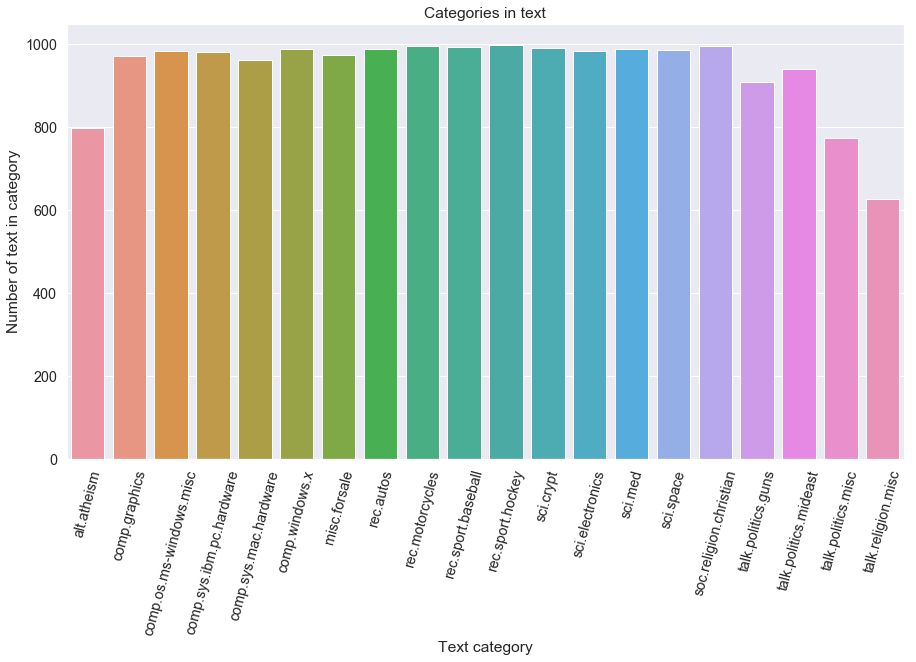

In [94]:
# print the histogramm with distribution of texts by categorieas and topics
plt.figure(figsize=(15,8))
sns.barplot(x="Category_Name", y="N_texts", data=df_print)
plt.xticks(rotation=75)
plt.xlabel('Text category');
plt.ylabel('Number of text in category');
plt.title("Categories in text");

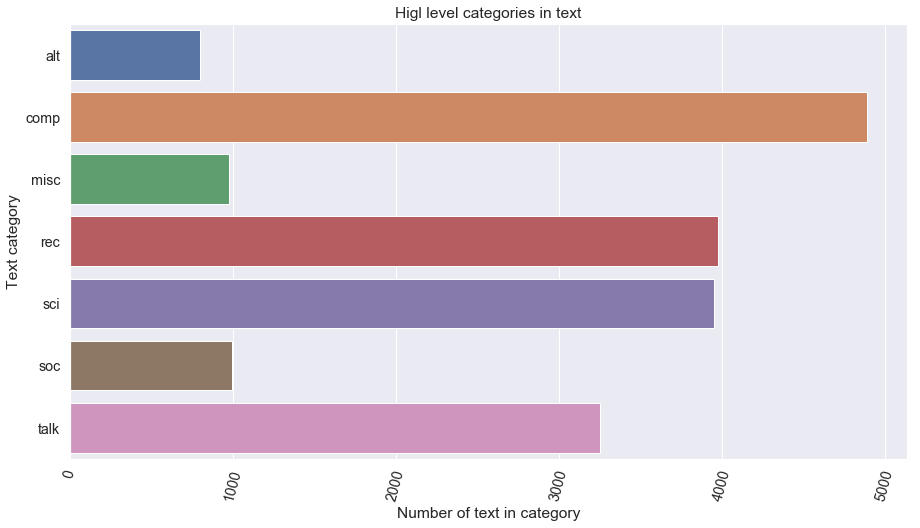

In [95]:
groupped_df = df_print.groupby('High_level_topic').agg({'N_texts': ['sum']})
groupped_df.columns = groupped_df.columns.droplevel(1)
groupped_df.reset_index(inplace=True)

plt.figure(figsize=(15,8))
sns.barplot(x="N_texts", y="High_level_topic", data=groupped_df)
plt.xticks(rotation=75)
plt.xlabel('Number of text in category');
plt.ylabel('Text category');
plt.title("Higl level categories in text");

Посмотрим на образец данных.

In [96]:
pprint(newsgroups_all.data[3])

("You can't call time when there's a play in progress.\n"
 '\n'
 'Ryan Robbins\n'
 'Penobscot Hall\n'
 'University of Maine')


In [78]:
newsgroups_all.target_names[newsgroups_all.target[1]]

'sci.space'

#### Data preprocessing.

Предобработаем данные, для этого:
- приведем все слова к нижнему регистру+.
- удалим знаки препинания+.
- заменим представление чисел в виде цифр на текстовые аналоги+.
- отсечем стоп слова (уберем символы и комбинации, которые не составляют смысловой нагрузки)+.
- проведем лемматизацию/стемминг (приведение слова к начальной форме с помощью словаря/выделение корня слова)+.
- удалим слова длиной 2 и менее символов+.
- выделим n-граммы (последовательности из нескольких слов, рассматриваемых как одно целое).

In [12]:
def remove_punctuation(text_punctuation,text):
    
    new_text = []
    #new_text = re.sub('['+text_punctuation+']', '',text)
    #new_text = re.sub('\n', ' ',new_text)
    for word in text:        
        new_word =  re.sub('\n', ' ',word)
        new_word =  re.sub('\t', ' ',new_word)
        new_word =  re.sub('['+text_punctuation+']', ' ',word)
        new_text.append(new_word)
    
    return new_text

In [13]:
def digits_to_text(text):
    p = inflect.engine()
    new_text = []
    for word in text:
        if word.isdigit():
            if len(word) > 18:
                print (list(text))
            else:
                new_word = p.number_to_words(word)
                new_text.append(new_word)
        else:
            new_text.append(word)
    #del p
    return new_text

In [14]:
def lemmatize_stemm_text(text):
    new_text_lemma = []
    new_text_stemm = []
    
    lemmatizer = WordNetLemmatizer()
    stemmer = LancasterStemmer()
    
    for word in text:
        lemma = lemmatizer.lemmatize(word, pos='v') # pay attention to pos='v' parameter!
        new_text_lemma.append(lemma)
        
        stemm = stemmer.stem(word)
        new_text_stemm.append(stemm)
        
    return new_text_lemma, new_text_stemm
        

In [15]:
def remove_stopwords(stop_words ,text):
    # обогатить stopwords? возможно стоит взять слова с tf-idf
    new_words = []
    new_words = [word for word in text
                  if word not in stop_words]
    return new_words

In [16]:
def remove_short_words(text, word_len):
    new_text = []
    for word in text:
        if len(word) >= word_len:
            new_text.append(word)
            
    return new_text

In [17]:
# getting source from string.punctuation, but removed right slash / and ^
text_punctuation = '!"#$%&\'()*+,-.:;<=>?@[\\]_`{|}~'

StopWords = list(set( stopwords.words('english') ).union( set(ENGLISH_STOP_WORDS)))
newStopWords = ['jfc','jb'] # по ходу работы периодически добавляем стоп-слова
newStopWords2 = ['arent', 'didnt', 'doesnt', 'dont', 'hadnt', 'havent', 'isnt', 
                 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'theres','thatll', 'wasnt', 
                 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve',
                 "'ll", "'re", "'ve", "n't", 'need', 'sha']
StopWords.extend(newStopWords)
StopWords.extend(newStopWords2)

def tokenize(text):
    min_length = 3
    
    #remove punctuation
    #text = remove_punctuation(text_punctuation, text)    
    
    # tokenize text
    words = word_tokenize(text,language='english')

    
    #words to lowercase
    words = map(lambda word: word.lower(), words)
    
    #remove punctuation
    text = remove_punctuation(text_punctuation, text)   
    
    #replace digits with words
    words = digits_to_text(words)
        
    # remove stopwords
    words = remove_stopwords(StopWords,words)
    
    #remove self-names https://stackoverflow.com/questions/20290870/improving-the-extraction-of-human-names-with-nltk
    #words =  drop_personal_names(list_names,words)
    
    #lemmatize or stemm words 
    words,_ = lemmatize_stemm_text(words)
    
    #filter short words
    words = remove_short_words(words, 3)
    
    #tokens = (list(map(lambda token: PorterStemmer().stem(token),
    #              words)));
    #p = re.compile('[a-zA-Z]+');
    #filtered_tokens = list(filter(lambda token:
    #              p.match(token) and len(token)>=min_length,tokens))
    return words#filtered_tokens

In [18]:
pprint(newsgroups_all.data[1]) #1,3,5

('\n'
 'jfc> If gamma ray bursters are extragalactic, would absorption from the\n'
 'jfc> galaxy be expected?  How transparent is the galactic core to gamma\n'
 'jfc> rays?\n'
 '\n'
 'and later...\n'
 '\n'
 'JB> So, if the 1/r^2 law is incorrect (assume\n'
 'JB> some unknown material [dark matter??] inhibits Gamma Ray propagation),\n'
 'JB> could it be possible that we are actually seeing much less energetic\n'
 'JB> events happening much closer to us?  The even distribution could\n'
 'JB> be caused by the characteristic propagation distance of gamma rays \n'
 'JB> being shorter then 1/2 the thickness of the disk of the galaxy.\n'
 '\n'
 '\n'
 ' 0.\n'
 '\n'
 ' Well, maybe not zero, but very little.  At the typical energies for \n'
 ' gamma rays, the Galaxy is effectively transparent. \n'
 '\n'
 ' Hans Bloemen had a review article in Ann. Rev. Astr. Astrophys. a few \n'
 ' years back in which he discusses this in more depth.')


In [19]:
%%time
test = tokenize(newsgroups_all.data[1])

Wall time: 2.56 s


In [20]:
test

['gamma',
 'ray',
 'bursters',
 'extragalactic',
 'absorption',
 'galaxy',
 'expect',
 'transparent',
 'galactic',
 'core',
 'gamma',
 'ray',
 'later',
 '...',
 '1/r^2',
 'law',
 'incorrect',
 'assume',
 'unknown',
 'material',
 'dark',
 'matter',
 'inhibit',
 'gamma',
 'ray',
 'propagation',
 'possible',
 'actually',
 'see',
 'energetic',
 'events',
 'happen',
 'closer',
 'distribution',
 'cause',
 'characteristic',
 'propagation',
 'distance',
 'gamma',
 'ray',
 'shorter',
 '1/2',
 'thickness',
 'disk',
 'galaxy',
 'zero',
 'maybe',
 'zero',
 'little',
 'typical',
 'energies',
 'gamma',
 'ray',
 'galaxy',
 'effectively',
 'transparent',
 'hans',
 'bloemen',
 'review',
 'article',
 'ann',
 'rev',
 'astr',
 'astrophys',
 'years',
 'discuss',
 'depth']

После того, как проверили работу токенизатора, извлечем фичи из текста с использованием TF-IDF.

Скачаем трейн/тест датасеты.

In [55]:
train_texts = fetch_20newsgroups(subset='test', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))
test_texts = fetch_20newsgroups(subset='train', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))

y_train, y_test = train_texts.target, test_texts.target

In [56]:
vectorizer = TfidfVectorizer(stop_words=StopWords,
                             tokenizer=tokenize, 
                             #min_df=0.05, # ignore terms with freq more that 0.05, lower majoring
                             #max_df=0.90, # ignore terms with freq more that 0.9, upper majoring
                             #max_features=3000,
                             use_idf=True,  #need this parameter
                             sublinear_tf=True,
                             norm='l2'                            
                            )

In [57]:
%%time
vectorised_train_documents = vectorizer.fit_transform(train_texts.data)
vectorised_test_documents = vectorizer.transform(test_texts.data)

Wall time: 3min 18s


Напишем функцию, которая будет производить:
- извлечение фич.
- вывод результатов работы классификатора.
- производить кросс-валидацию по 5 фолдам.

In [268]:
def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    tfidf_params = {
        'stop_words' : StopWords,
        'tokenizer':tokenize,
        'use_idf':True,
        'sublinear_tf':True,
        'norm':'l2'
    }
    clf = Pipeline([('vect', TfidfVectorizer(** tfidf_params)), ('classifier', classifier)])
    
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='micro')

    #print ("Test score")
    #pred_test = clf.predict(X_test)
    #f1_test = f1_score(y_test, pred_test, average='micro')
    
    my_scorer = make_scorer(f1_score, average='weighted')
    skv = StratifiedKFold(n_splits = 5,random_state=seed, shuffle=True)
    f1_test = cross_val_score(clf, X_test, y_test, cv=skv, scoring=my_scorer,n_jobs = -1).mean()
    
    return f1_train, f1_test

In [242]:
results_df = []
results_df = pd.DataFrame(columns=('Algorithm', 'Train_score', 'Test_score_cv', 'parameters'))

In [269]:
# TEST BLOCK

alphas = [0.01 , 0.015, 0.02]

for alph in alphas:
    a = "MultinomialNB"
    b,c = classify_and_score(MultinomialNB(alpha=alph), train_texts.data, 
                           test_texts.data, y_train, y_test)
    d = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':a, 'Train_score':b,'Test_score_cv':c, 'parameters':d},ignore_index=True)

In [270]:
results_df

,Algorithm,Train_score,Test_score_cv,parameters
0,MultinomialNB,0.962161,0.721830,alpha = 0.0001
1,MultinomialNB,0.961498,0.735421,alpha = 0.001
2,MultinomialNB,0.959639,0.745617,alpha = 0.005
3,MultinomialNB,0.958444,0.746701,alpha = 0.01
4,MultinomialNB,0.958046,0.745710,alpha = 0.015
5,MultinomialNB,0.957116,0.744548,alpha = 0.02
6,MultinomialNB,0.956187,0.743152,alpha = 0.025
7,MultinomialNB,0.955789,0.742288,alpha = 0.03
8,MultinomialNB,0.954859,0.742006,alpha = 0.035
9,MultinomialNB,0.954195,0.741108,alpha = 0.04


In [273]:
SGDClassifier(loss = 'hinge', penalty = 'elasticnet',
              alpha = 0.01, l1_ratio = 0.15,
              max_iter = 6, tol = 1e-3,
              n_jobs = -1, random_state = seed,
              learning_rate = 'optimal', #adaptive?
              class_weight = 'balanced'
             )
SVC 

# compare hinge loss == linear SVM
# compare other different kernels

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=6,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='elasticnet',
       power_t=0.5, random_state=321, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [243]:
#actual block of code
alphas = [0.0001,0.001,0.005 ,0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01,2,5]

for alph in alphas:
    a = "MultinomialNB"
    b,c = classify_and_score(MultinomialNB(alpha=alph), vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    d = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':a, 'Train_score':b,'Test_score_cv':c, 'parameters':d},ignore_index=True)
    
    
for alph in alphas:
    a = "BernoulliNB"
    b,c = classify_and_score(BernoulliNB(alpha=alph), vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    d = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':a, 'Train_score':b,'Test_score_cv':c, 'parameters':d},ignore_index=True)

In [272]:
results_df[results_df.Test_score_cv >=  results_df.Test_score_cv.max()]

,Algorithm,Train_score,Test_score_cv,parameters
103,MultinomialNB,0.958444,0.755592,alpha = 0.015


GaussianNB не использовался, т.к. на вход этому алгоритму требуется dense, а не sparce-матрица.
При выполнении преобразования todense()/toarray() потребление памяти существенно возросло и привело к тому, что массив не помещяется в память.

In [114]:
"""clf = GaussianNB()
clf.fit(vectorised_train_documents.toarray(), y_train)
pred = clf.predict(vectorised_test_documents.toarray())
f1_score(y_test, pred, average='micro')"""

"clf = GaussianNB()\nclf.fit(vectorised_train_documents.toarray(), y_train)\npred = clf.predict(vectorised_test_documents.toarray())\nf1_score(y_test, pred, average='micro')"